In [ ]:
import os, re, math, json, shutil, pprint, csv, sys, re, pickle
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

BATCH_SIZE = 64
EPOCHS = 100
NUM_DATA = 32298
IMG_W = 48
IMG_H = 48
#CHANGE VALIDATION AND TRAINING LABELS AXIS
#CHANGE DROP_REMAINDER FOR BATCHES

drive.mount('/content/drive')
trainPath  = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\Data\trainBackup.csv"
testPath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\Data\test.csv"
dataPath = r"/content/drive/MyDrive/icml_face_data.csv"
controlPath = r"/content/drive/MyDrive/data_filtered_none.csv"
upsideDownPath = r"/content/drive/MyDrive/data_filtered_upside_down.csv"
coverEyesPath = r"/content/drive/MyDrive/data_filtered_cover_eyes.csv"
coverMouthPath = r"/content/drive/MyDrive/data_filtered_cover_mouth.csv"

Tensorflow version 2.9.2
Mounted at /content/drive


In [ ]:
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

class PlotTraining(tf.keras.callbacks.Callback):
    def __init__(self, sample_rate=1, zoom=1):
        self.sample_rate = sample_rate
        self.step = 0
        self.zoom = zoom
        self.steps_per_epoch = NUM_DATA//BATCH_SIZE

    def on_train_begin(self, logs={}):
        self.batch_history = {}
        self.batch_step = []
        self.epoch_history = {}
        self.epoch_step = []
        self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
        plt.ioff()

    def on_batch_end(self, batch, logs={}):
        if (batch % self.sample_rate) == 0:
            self.batch_step.append(self.step)
            for k,v in logs.items():
                # do not log "batch" and "size" metrics that do not change
                # do not log training accuracy "acc"
                if k=='batch' or k=='size':# or k=='acc':
                    continue
                self.batch_history.setdefault(k, []).append(v)
        self.step += 1

    def on_epoch_end(self, epoch, logs={}):
        plt.close(self.fig)
        self.axes[0].cla()
        self.axes[1].cla()

        self.axes[0].set_ylim(0, 1.2/self.zoom)
        self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)

        self.epoch_step.append(self.step)
        for k,v in logs.items():
          # only log validation metrics
          if not k.startswith('val_'):
            continue
          self.epoch_history.setdefault(k, []).append(v)

        display.clear_output(wait=True)

        for k,v in self.batch_history.items():
            self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)

        for k,v in self.epoch_history.items():
            self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)

        self.axes[0].legend()
        self.axes[1].legend()
        self.axes[0].set_xlabel('epochs')
        self.axes[1].set_xlabel('epochs')
        self.axes[0].minorticks_on()
        self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
        self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
        self.axes[1].minorticks_on()
        self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
        self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
        display.display(self.fig)

In [ ]:
data = pd.read_csv(dataPath)
data.columns = ['emotion', 'Usage', 'pixels']
print(data.shape)

testDS = data.loc[data["Usage"] == 'PrivateTest',['emotion','pixels']]
trainDS = data.loc[data["Usage"] != 'PrivateTest',['emotion','pixels']]

print(len(trainDS))

trainDS['pixels'] = [np.fromstring(line, dtype=int, sep=' ').reshape(-1,48,48,1) for line in trainDS['pixels']]
testDS['pixels'] = [np.fromstring(line, dtype=int, sep=' ').reshape(-1,48,48,1) for line in testDS['pixels']]

trainPixels = np.concatenate(trainDS['pixels'])

labelEncoder = LabelEncoder()
labels = labelEncoder.fit_transform(trainDS.emotion)
labels = tf.keras.utils.to_categorical(labels)

testPixels = np.concatenate(testDS['pixels'].values)

trainX, testX, trainY, testY = train_test_split(
    trainPixels, labels, test_size = 0.5, stratify=labels, random_state=1
)


print('trainX', trainX.shape)
print('trainY:', trainY.shape)
print('testX Shape:', testX.shape)
print('testY Shape:', testY.shape)


(35887, 3)
32298
trainX (16149, 48, 48, 1)
trainY: (16149, 7)
testX Shape: (16149, 48, 48, 1)
testY Shape: (16149, 7)


In [ ]:
trainDatagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

trainDatagen.fit(trainX)

testDatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

trainFlow = trainDatagen.flow(trainX, trainY, batch_size=64)
testFlow = testDatagen.flow(testX, testY, batch_size=64)


overfitProtection = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.00005,
    patience = 20,
    verbose = 1,
    restore_best_weights = True
)

lrScheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.5,
    patience = 15,
    min_lr = 1e-7,
    verbose = 1
)

plot_training = PlotTraining(sample_rate=10, zoom=0.55)

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)
num_classes = 7

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(48,48,1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    


    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    


    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    


    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    


    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            metrics=['accuracy', tf.keras.metrics.AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

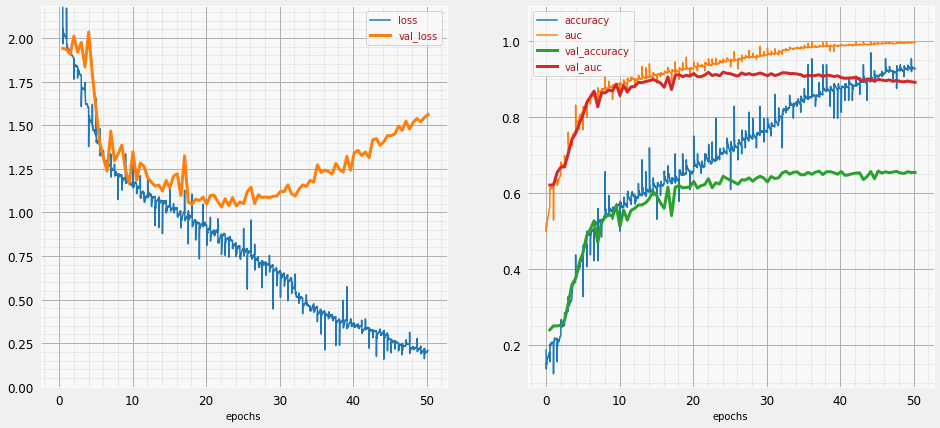

252/252 [==============================] - 26s 104ms/step - loss: 0.2074 - accuracy: 0.9270 - auc: 0.9953 - val_loss: 1.5610 - val_accuracy: 0.6544 - val_auc: 0.8913 - lr: 1.2500e-04


In [ ]:
history = model.fit(
    trainFlow,
    steps_per_epoch=len(trainX) / BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=testFlow,
    validation_steps=len(testX) / BATCH_SIZE,
    callbacks=[overfitProtection, lrScheduler, plot_training],
    workers=8)

In [ ]:
# Evaluation on Control Test Set

controlData = pd.read_csv(controlPath)
controlData.columns = ['emotion', 'Usage', 'pixels']
print(controlData.shape)

controlDS = controlData.loc[controlData["Usage"] == 'PrivateTest',['emotion','pixels']]

print(len(controlDS))

controlDS['pixels'] = [np.fromstring(line, dtype=int, sep=' ').reshape(-1,48,48,1) for line in controlDS['pixels']]

controlPixels = np.concatenate(controlDS['pixels'])

labelEncoder = LabelEncoder()
labels = labelEncoder.fit_transform(controlDS.emotion)
labels = tf.keras.utils.to_categorical(labels)

# testPixels = np.concatenate(testDS['pixels'].values)

cTrainX, controlX, cTrainY, controlY = train_test_split(
    controlPixels, labels, test_size = 3581, stratify=labels, random_state=1
)

controlDatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
controlFlow = testDatagen.flow(controlX, controlY, batch_size=64)

testLoss, testAcc, testAUC = model.evaluate(controlFlow, verbose=0)
print(f'Control Accuracy: {testAcc:.3f}')
print(f'Control AUC: {testAUC:.3f}')
print(f'Control Loss: {testLoss:.3f}')

(3588, 3)
3588
Control Accuracy: 0.662
Control AUC: 0.898
Control Loss: 1.498


In [ ]:
# Evaluation on Cover Mouth Test Set

covermouthData = pd.read_csv(coverMouthPath)
covermouthData.columns = ['emotion', 'Usage', 'pixels']
print(covermouthData.shape)

covermouthDS = covermouthData.loc[covermouthData["Usage"] == 'PrivateTest',['emotion','pixels']]

print(len(covermouthDS))

covermouthDS['pixels'] = [np.fromstring(line, dtype=int, sep=' ').reshape(-1,48,48,1) for line in covermouthDS['pixels']]

covermouthPixels = np.concatenate(covermouthDS['pixels'])

labelEncoder = LabelEncoder()
labels = labelEncoder.fit_transform(covermouthDS.emotion)
labels = tf.keras.utils.to_categorical(labels)

# testPixels = np.concatenate(testDS['pixels'].values)

cmTrainX, covermouthX, cmTrainY, covermouthY = train_test_split(
    covermouthPixels, labels, test_size = 3581, stratify=labels, random_state=1
)

covermouthDatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
covermouthFlow = testDatagen.flow(covermouthX, covermouthY, batch_size=64)

testLoss, testAcc, testAUC = model.evaluate(covermouthFlow, verbose=0)
print(f'Cover Mouth Accuracy: {testAcc:.3f}')
print(f'Cover Mouth AUC: {testAUC:.3f}')
print(f'Cover Mouth Loss: {testLoss:.3f}')

(3588, 3)
3588
Cover Mouth Accuracy: 0.406
Cover Mouth AUC: 0.755
Cover Mouth Loss: 2.676


In [ ]:
# Evaluation on Cover Eyes Test Set

covereyesData = pd.read_csv(coverEyesPath)
covereyesData.columns = ['emotion', 'Usage', 'pixels']
print(covereyesData.shape)

covereyesDS = covereyesData.loc[covereyesData["Usage"] == 'PrivateTest',['emotion','pixels']]

print(len(covereyesDS))

covereyesDS['pixels'] = [np.fromstring(line, dtype=int, sep=' ').reshape(-1,48,48,1) for line in covereyesDS['pixels']]

covereyesPixels = np.concatenate(covereyesDS['pixels'])

labelEncoder = LabelEncoder()
labels = labelEncoder.fit_transform(covereyesDS.emotion)
labels = tf.keras.utils.to_categorical(labels)

# testPixels = np.concatenate(testDS['pixels'].values)

ceTrainX, covereyesX, ceTrainY, covereyesY = train_test_split(
    covereyesPixels, labels, test_size = 3581, stratify=labels, random_state=1
)

covereyesDatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
covereyesFlow = testDatagen.flow(covereyesX, covereyesY, batch_size=64)

testLoss, testAcc, testAUC = model.evaluate(covereyesFlow, verbose=0)
print(f'Cover Eyes Accuracy: {testAcc:.3f}')
print(f'Cover Eyes AUC: {testAUC:.3f}')
print(f'Cover Eyes Loss: {testLoss:.3f}')

(3588, 3)
3588
Cover Eyes Accuracy: 0.421
Cover Eyes AUC: 0.735
Cover Eyes Loss: 3.435


In [ ]:
# Evaluation on Upside Down Test Set

upsidedownData = pd.read_csv(upsideDownPath)
upsidedownData.columns = ['emotion', 'Usage', 'pixels']
print(upsidedownData.shape)

upsidedownDS = upsidedownData.loc[upsidedownData["Usage"] == 'PrivateTest',['emotion','pixels']]

print(len(upsidedownDS))

upsidedownDS['pixels'] = [np.fromstring(line, dtype=int, sep=' ').reshape(-1,48,48,1) for line in upsidedownDS['pixels']]

upsidedownPixels = np.concatenate(upsidedownDS['pixels'])

labelEncoder = LabelEncoder()
labels = labelEncoder.fit_transform(upsidedownDS.emotion)
labels = tf.keras.utils.to_categorical(labels)

# testPixels = np.concatenate(testDS['pixels'].values)

uTrainX, upsidedownX, uTrainY, upsidedownY = train_test_split(
    upsidedownPixels, labels, test_size = 3581, stratify=labels, random_state=1
)

upsidedownDatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
upsidedownFlow = testDatagen.flow(upsidedownX, upsidedownY, batch_size=64)

testLoss, testAcc, testAUC = model.evaluate(upsidedownFlow, verbose=0)
print(f'Upside Down Accuracy: {testAcc:.3f}')
print(f'Upside Down AUC: {testAUC:.3f}')
print(f'Upside Down Loss: {testLoss:.3f}')

(3588, 3)
3588
Upside Down Accuracy: 0.184
Upside Down AUC: 0.559
Upside Down Loss: 4.684
